# Тестовое задание

Реализовать и обучить модель, позволяющую выполнять иерархическую семантическую сегментацию.

Обучать модель предлагается на датасете Pascal-part.


### Данные

Обучение модели предлагается производить на датасете Pascal-part.
Подготовленные данные и разметку можно загрузить по следующей [ссылке](https://drive.google.com/file/d/1unIkraozhmsFtkfneZVhw8JMOQ8jv78J/view?usp=sharing).

В папке `JPEGImages` находятся исходные изображения в формате jpeg. В папке `gt_masks` находятся маски сегментации в формате numpy.
Загрузить маски можно при помощи функции `numpy.load()`.

В датасете присутствуют 7 классов, обладающих следующей иерархической структурой (в скобках указан индекс класса):

```
├── (0) background
└── body
    ├── upper_body
    |   ├── (1) low_hand
    |   ├── (6) up_hand
    |   ├── (2) torso
    |   └── (4) head
    └── lower_body
        ├── (3) low_leg
        └── (5) up_leg
```

### Метрики

В качестве основной метрики предлагается использовать mean Intersection over Union (mIoU).
Для каждого из уровней вложенности предлагается вычислять метрику отдельно.
При этом background класс не учитывается при рассчете метрики.
Таким образом, для полученной модели необходимо оценить 3 значения метрик по следующим категориям:

* mIoU<sup>0</sup> - `body`
* mIou<sup>1</sup> - `upper_body`, `lower_body`
* mIoU<sup>2</sup> - `low_hand`, `up_hand`, `torso`, `head`, `low_leg`, `up_leg`

### Что будет оцениваться?
1. Оформление кода на github.
2. Оформление результатов.
3. Структура репозитория.
4. Соответствие решения тестовому заданию.
5. Любые релевантные теме мысли, идеи и соображения.


# Import

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import cv2
import gc
import tqdm

In [3]:
from torchvision.models import detection
from torchvision.models import segmentation
from torchvision import transforms
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchmetrics 

from skimage.measure import label, regionprops
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader

# Constants

In [5]:
IMG_PATH = '/kaggle/input/pascalpart/Pascal-part/JPEGImages/'
MASK_PATH = '/kaggle/input/pascalpart/Pascal-part/gt_masks'

In [6]:
NUM_CLASS = 7
SEED = 1337

In [7]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [8]:
torch.manual_seed(SEED)

# Utils

In [9]:
def mask_splitter():
    pass

def tensor_to_numpy(t):
    return t.cpu().detach().numpy()

# Data

In [10]:
image_pathes = glob.glob('/kaggle/input/pascalpart/Pascal-part/JPEGImages/*.jpg')

In [11]:
len(image_pathes)

3533

In [12]:
with open('/kaggle/input/pascalpart/Pascal-part/classes.txt', 'r') as f:
    classes = f.read().split('\n')
    classes_dict = {}
    for class_line in classes:
        c, c_name = class_line.split(': ')
        c = int(c)
        classes_dict[c] = c_name

In [13]:
classes_dict

{0: 'bg',
 1: 'low_hand',
 2: 'torso',
 3: 'low_leg',
 4: 'head',
 5: 'up_leg',
 6: 'up_hand'}

In [14]:
with open('/kaggle/input/pascalpart/Pascal-part/train_id.txt', 'r') as f:
    train_ids = f.read().split('\n')


with open('/kaggle/input/pascalpart/Pascal-part/val_id.txt', 'r') as f:
    valid_ids = f.read().split('\n')

## Images information

In [15]:
image_info = pd.DataFrame(columns=['id', 'width', 'height', 'classes'])

for path in image_pathes:
    img = Image.open(path)
    img_id = path.split('/')[-1][:-4]
    width, height = img.size
    
    mask = np.load(f'/kaggle/input/pascalpart/Pascal-part/gt_masks/{img_id}.npy')
    classes = np.unique(mask)
    
    image_info = image_info.append({
        'id': img_id,
        'width': width,
        'height': height,
        'classes': list(classes)
    }, ignore_index=True)
    
#     break

In [16]:
image_info.head()

,id,width,height,classes
0,2009_004042,500,375,"[0, 1, 2, 4, 5, 6]"
1,2008_001283,500,375,"[0, 1, 2, 4, 6]"
2,2009_002705,500,375,"[0, 4]"
3,2008_004991,480,359,"[0, 1, 2, 3, 4, 5, 6]"
4,2008_002942,500,467,"[0, 2, 4, 6]"


In [17]:
image_info['width'].nunique(), image_info['height'].nunique()

(163, 212)

In [18]:
image_info['width'].mean(), image_info['height'].mean() 

(464.6532691763374, 391.1500141522785)

<AxesSubplot:xlabel='height'>

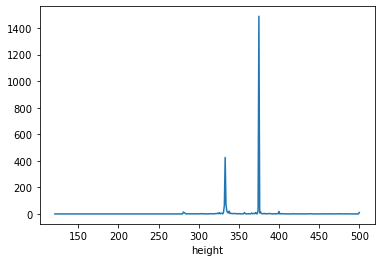

In [19]:
image_info[image_info['width'] == 500].groupby('height')['id'].count().plot()

<AxesSubplot:xlabel='width'>

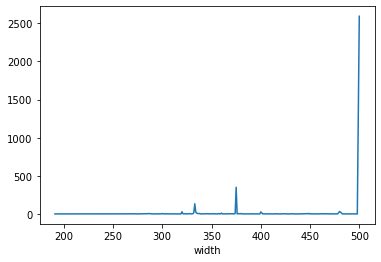

In [20]:
image_info.groupby('width')['id'].count().plot()

In [21]:
gp_height = image_info.groupby('height')['id'].count().reset_index()
gp_height.iloc[gp_height['id'].argmax()]

height     375
id        1489
Name: 119, dtype: int64

In [22]:
gp_width = image_info.groupby('width')['id'].count().reset_index()
gp_width.iloc[gp_width['id'].argmax()]

width     500
id       2592
Name: 162, dtype: int64

## Dataset

In [23]:
class PascalPartDataset(Dataset):
    
    def __init__(self,
                 image_info,
                 sample_ids,
                 transform=None,
                ):
        self.image_info = image_info
        self.sample_ids = sample_ids
        self.transforms = transform
        
        self.image_info = self.image_info[self.image_info['id'].isin(sample_ids)]
        
    
    def get_image(self, path):
        img = Image.open(path)
        return img
    
    def get_mask(self, path):
        mask = np.load(path)
        return mask
    
    def split_mask(self, mask):
        labels = list(range(7))
        labels_and_masks = []
        
        for label in labels:
            temp_mask = np.array(mask == label, dtype=int)
            labels_and_masks.append((label, temp_mask))
        
        return labels_and_masks
    
    def get_bbox_from_mask(self, labels_and_masks):
        bboxes = []
        targets = []
        masks = []
        filter_mask = []
        for target, mask in labels_and_masks:
            labels = label(mask)
            y1, x1, y2, x2 = (0, 0, 0, 0)
            
            try:
                props = regionprops(labels)[0]
                y1, x1, y2, x2 = props.bbox
                filter_mask.append(True)
            except:
                filter_mask.append(False)
            
            bbox = [x1, y1, x2, y2]
            bboxes.append(bbox)
            targets.append(target)
            masks.append(mask)
        
        return targets, bboxes, masks, filter_mask
    
    def __len__(self):
        return len(self.sample_ids)
    
    def __getitem__(self, idx):
        idx = self.sample_ids[idx]
        img_path = os.path.join(IMG_PATH, idx + '.jpg')
        mask_path = os.path.join(MASK_PATH, idx + '.npy')
        
        img = self.get_image(img_path)
        mask = self.get_mask(mask_path)
        
        transformed = self.transforms(image=np.array(img), mask=mask)
        img = torch.Tensor(transformed['image']).to(DEVICE).permute(2,0,1)
    
        labels_and_masks = self.split_mask(transformed['mask'])
        labels, bboxes, masks, filter_mask = self.get_bbox_from_mask(labels_and_masks)
        bboxes = torch.Tensor(bboxes).to(DEVICE)
        labels = torch.Tensor(labels).type(torch.LongTensor).to(DEVICE)
        filter_mask = np.array(filter_mask)
        
        mask = torch.Tensor(transformed['mask']).type(torch.LongTensor).to(DEVICE)
        masks = torch.Tensor(masks).to(DEVICE)
    
        return img, {'mask': mask, 'masks': masks, 'labels': labels, 'boxes': bboxes}, filter_mask

In [24]:
transform = A.Compose([
    A.Normalize(),
    A.Resize(height=520, width=520),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
])

In [25]:
train_dataset = PascalPartDataset(image_info, train_ids, transform=transform)
valid_dataset = PascalPartDataset(image_info, valid_ids, transform=transform)

In [27]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=5,
                              shuffle=True
                             )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=5,
                              shuffle=True
                             )

# Model

In [31]:
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, NUM_CLASS, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[-1] = torch.nn.Conv2d(256, NUM_CLASS, kernel_size=(1, 1), stride=(1, 1))

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

## Training

## Initialization

In [32]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, logits, targets):
        
        N = targets.size(0)
        preds = torch.sigmoid(logits)
        
        EPSILON = 1e-7
        
        # Flattening the final layer 
        preds_flat = preds.view(N,-1)
        targets_flat = targets.view(N, -1)
        
        intersection = (preds_flat * targets_flat).sum()
        union = (preds_flat + targets_flat).sum()
        
        loss = (2.0 * intersection + EPSILON) / (union + EPSILON)
        loss = 1 - loss / N
        return loss

In [58]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = DiceLoss()

In [65]:
def inference_func(batch, model, optimizer, loss_fn, metric_fn=None):
    X = batch[0]
    y = batch[1]['masks']
    preds = model(X)['out']
    loss = loss_fn(preds, y)
    metric = None
    if metric_fn:
        metric = metric_fn(preds, y)
        
    if model.training:
        optimizer.zero_grad()        
        loss.backward()        
        optimizer.step()
    
    return loss.item(), metric
    

def process_function(data, model, optimizer, loss_fn, print_step=10, metric_fn=None):
    # model should be in train state during training and in eval state during evaluation
    
    loss_history = []
    metric_history = []
    data = tqdm.tqdm(data)
    
    for i, batch in enumerate(data):
        if batch[0].shape[0] < 2:
            # if batch consists of less than 2 elements skip the step
            break
        
        out = inference_func(batch,
                             model,
                             optimizer,
                             loss_fn,
                             metric_fn=metric_fn)
        loss_value, metric_value = out
        loss_history.append(loss_value)
        metric_history.append(metric_value)
        
        if i % print_step == 0 and i != 0:
            round_loss = round(np.mean(loss_history[i - print_step: i]), 5)
            if not metric_fn:
                data.set_description(f'loss: {round_loss}')
            elif metric_fn:
                round_metric = round(np.mean(metric_history[i - print_step: i]), 5)
                data.set_description(f'loss: {round_loss}, metric: {round_metric}')

    return loss_history, metric_history 


In [66]:
EPOCHS = 8
train_loss_history = []
valid_loss_history = []
print_step_size = 10

for epoch in range(EPOCHS):
    print(f'Training epoch N{epoch} begins')
    model.train()
    train_epoch_loss_history, _ = process_function(train_dataloader, model, optimizer, loss_fn, print_step=10, metric_fn=None)
    train_loss_history += train_epoch_loss_history
    
    print(f'Evaluation epoch N{epoch} begins')
    model.eval()
    valid_epoch_loss_history, _ = process_function(valid_dataloader, model, optimizer, loss_fn, print_step=10, metric_fn=None)
    valid_loss_history += valid_epoch_loss_history

    print("Save model to:", str(epoch) + ".torch")
    torch.save(model.state_dict(), str(epoch) + ".torch")
    

Training epoch N0 begins


loss: 0.20704: 100%|█████████▉| 565/566 [17:16<00:01,  1.83s/it]


Evaluation epoch N0 begins


loss: 0.31115: 100%|██████████| 142/142 [02:48<00:00,  1.19s/it]


Save model to: 0.torch
Training epoch N1 begins


loss: 0.21355: 100%|█████████▉| 565/566 [17:15<00:01,  1.83s/it]


Evaluation epoch N1 begins


loss: 0.29055: 100%|██████████| 142/142 [02:46<00:00,  1.17s/it]


Save model to: 1.torch
Training epoch N2 begins


loss: 0.20354: 100%|█████████▉| 565/566 [17:17<00:01,  1.84s/it]


Evaluation epoch N2 begins


loss: 0.23558: 100%|██████████| 142/142 [02:44<00:00,  1.16s/it]


Save model to: 2.torch
Training epoch N3 begins


loss: 0.13302: 100%|█████████▉| 565/566 [17:16<00:01,  1.83s/it]


Evaluation epoch N3 begins


loss: 0.21023: 100%|██████████| 142/142 [02:53<00:00,  1.22s/it]


Save model to: 3.torch
Training epoch N4 begins


loss: 0.14101: 100%|█████████▉| 565/566 [17:03<00:01,  1.81s/it]


Evaluation epoch N4 begins


loss: 0.20286: 100%|██████████| 142/142 [02:42<00:00,  1.14s/it]


Save model to: 4.torch
Training epoch N5 begins


loss: 0.13569: 100%|█████████▉| 565/566 [16:57<00:01,  1.80s/it]


Evaluation epoch N5 begins


loss: 0.22751: 100%|██████████| 142/142 [02:41<00:00,  1.14s/it]


Save model to: 5.torch
Training epoch N6 begins


loss: 0.13783: 100%|█████████▉| 565/566 [16:55<00:01,  1.80s/it]


Evaluation epoch N6 begins


loss: 0.2438: 100%|██████████| 142/142 [02:41<00:00,  1.14s/it] 


Save model to: 6.torch
Training epoch N7 begins


loss: 0.12791: 100%|█████████▉| 565/566 [16:59<00:01,  1.80s/it]


Evaluation epoch N7 begins


loss: 0.23797: 100%|██████████| 142/142 [02:42<00:00,  1.14s/it]


Save model to: 7.torch


In [ ]:
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# with train_summary_writer.as_default():
#     tf.summary.scalar('loss', train_loss.result(), step=epoch)
#     tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)


In [92]:
train_epoch_mean = []
valid_epoch_mean = []

for i in range(1, EPOCHS):
    train_epoch_mean.append(np.mean(train_loss_history[(i - 1) * 565: i * 565]))
    valid_epoch_mean.append(np.mean(valid_loss_history[(i - 1) * 141: i * 141]))

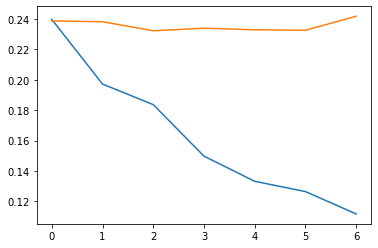

In [93]:
plt.plot(train_epoch_mean)
plt.plot(valid_epoch_mean)

In [94]:
model.eval()
img_v, data_v, filter_mask_v = valid_dataset[30]
preds_v = model(img_v[None])['out']

[0 1 2 4 5 6]


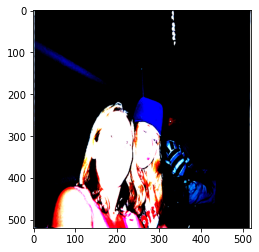

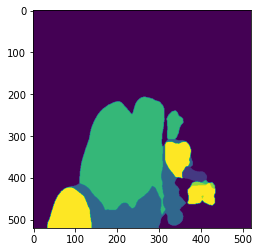

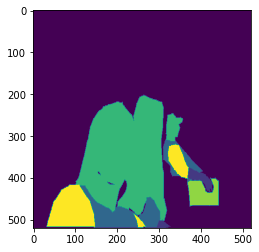

In [95]:
img_1 = tensor_to_numpy(img_v.permute(1,2,0))
mask_1 = tensor_to_numpy(torch.argmax(preds_v[0], dim=0))
print(np.unique(mask_1))
plt.imshow(img_1 + 0.5)
plt.show()
# plt.imshow(np.mean(img_1, axis=2) * mask_1)
plt.imshow(mask_1)
plt.show()
plt.imshow(tensor_to_numpy(data_v['mask']))

# mIoU

In [131]:
mIoU_0_func = torchmetrics.JaccardIndex('binary')
mIoU_1_func = torchmetrics.JaccardIndex('multiclass', num_classes=3)
mIoU_2_func = torchmetrics.JaccardIndex('multiclass', num_classes=NUM_CLASS)


## Body parts initialization

In [141]:
# mIoU_0 - body| 2 classes bg and body
# mIoU_1 - upper_body, lower_body| 3 classes bg, upper_body and lower_body
# mIoU_2 - low_hand, up_hand, torso, head, low_leg, up_leg| default 7 classes.

body = [1, 2, 3, 4, 5, 6]
upper_body = [1, 2, 4, 6]
lower_body = [3, 5]

## Calculate IoU

In [171]:
# mask tensor
# calculate iou
# save into an array
# calculate mean

def get_pred(pred):
    return torch.argmax(pred, dim=0)

def binary_mask_tensor(t: torch.Tensor, classes: list) -> torch.Tensor:
    return torch.isin(t, torch.Tensor(classes)).type(torch.LongTensor)


def mask_tensor(t: torch.Tensor, classes_list: list) -> torch.Tensor:
    if len(classes_list) > 1:
        final_tensor = torch.zeros(t.size())
        cur_class = 1
        for classes in classes_list:
            final_tensor += binary_mask_tensor(t, classes) * cur_class
            cur_class += 1
    else:
        final_tensor = binary_mask_tensor(t, classes_list[0])
        
    return final_tensor

def get_miou(data, model, iou_fn, classes=None):
    if model.training:
        raise AssertionError('model should be in the evaluation state')
    
    miou_values = []
    
    for img, targets, _ in tqdm.tqdm(data):
        mask = targets['mask'].cpu()
        
        pred = model(img[None])['out'].cpu()
        pred = torch.argmax(pred[0], dim=0)
        
        if classes:
            pred = mask_tensor(pred, classes)
            mask = mask_tensor(mask, classes)
            
        iou = iou_fn(pred.cpu(), mask.cpu())
        
        miou_values.append(iou.item())
    
    return miou_values
        

## mIoU results

In [175]:
mIoU_0 = get_miou(valid_dataset, model, mIoU_0_func, classes=[body])

100%|██████████| 707/707 [03:43<00:00,  3.16it/s]


In [176]:
np.mean(mIoU_0)

0.7274202419520004

In [177]:
mIoU_1 = get_miou(valid_dataset, model, mIoU_1_func, classes=[upper_body, lower_body])

100%|██████████| 707/707 [03:51<00:00,  3.06it/s]


In [178]:
np.mean(mIoU_1)

0.6733741463073747

In [167]:
mIoU_2 = get_miou(valid_dataset, model, mIoU_2_func)

100%|██████████| 707/707 [03:04<00:00,  3.82it/s]


In [169]:
np.mean(mIoU_2)

0.5017896421158836

# Final toughts

- На графике с обучением модели можно заметить, что модель изрядно переобучается и то, что обучение можно остановить после 1 эпохи, но anyway после 1 эпохи качество модели гораздо хуже на valid, чем на 8 эпохах. Необходимо параллельно при обучении смотреть еще и метрику IoU для лучшего понимания ситуации.
- Также можно перестроить Dataset на выдачу сэмплов из train и из valid чтобы при обучении сразу же проверять качество метрик. Думаю, было бы удобно.
- Можно добавить аугментацию для увеличения выборки и повышения стабильности модели.
- Можно использовать функцию потерь DiceLoss. Так как итоговые метрики, на которые мы ориентируемся, это IoU, то DiceLoss кажется хорошим выбором. В этом случае я строил больше бейзлайн, чем топ модель поэтому и выбрал CE.
- CE достаточно высокий и на train, хоть и видно, что он еще падает, но из-за лимита времени остановился на 8 эпохах. Из-за чего можно попробовать более глубокую версию модели с resnet101
